# Perspective experiments

In order to accurately calculate the voronoi diagram for an image, we need to transform the sites from pixel space to real-world space

To do this, we need to find a homography matrix 

This can be found using `cv2.getPerspectiveTransform()` with four points that should be rectangular in real-world space
Finding these four points is not straightforward.

In [1]:
import math
from collections import namedtuple

%matplotlib inline
import cv2
import numpy as np

from matplotlib import pyplot as plt


## Display the image

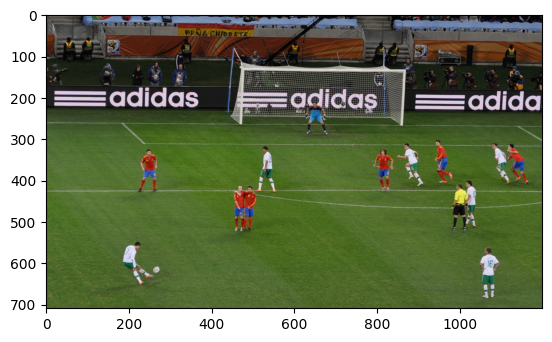

In [2]:
img = cv2.imread("../../data/spain-portugal.jpg")


# cv2.imshow("img", img)
# cv2.waitKey(0)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Part 1: Demonstrate the perspective warp

In order to experiment with the perspective transform without worrying about detecting points correct, we can manually eyeball the pixel locations of the penalty box


In [3]:
eyeballed_points = np.float32([
    [187,264],
    [238,312],
    [1144,272],
    [1210,320]  # especially eyeballed as this goes outside the bounds of the image
])


# the size of a penalty area in metres
penalty_area_dimensions = np.float32([
    [0,0],
    [0,16.5],
    [40.2, 0],
    [40.2,16.5]
])

In [4]:
# the x10 multiplcation here is completely arbitrary to make the warpPerspective plot reasonably nicely
# for the actual project, we only need the homography matrix 
pen_dims_scaled = penalty_area_dimensions * 10

hom_mat = cv2.getPerspectiveTransform(eyeballed_points, pen_dims_scaled)
print(hom_mat)

[[ 4.63377448e-01 -4.92338539e-01  4.33257914e+01]
 [-3.22850986e-02  3.86210492e+00 -1.01355838e+03]
 [-6.05276744e-06  3.68535124e-04  1.00000000e+00]]


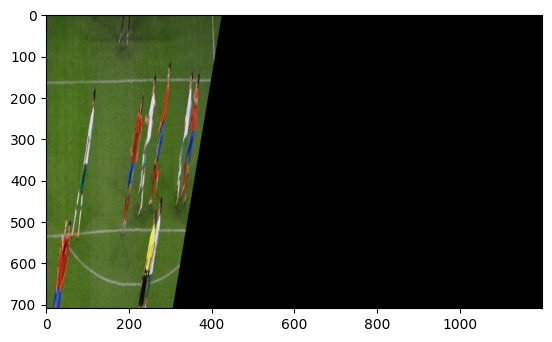

In [5]:
warped_img = cv2.warpPerspective(img, hom_mat, (img.shape[1], img.shape[0]))
plt.imshow(warped_img)
plt.show()
                                 

This seems to work as desired - the penalty area looks roughly straight


# Part 2: Detect coordinates

To do this properly we need to work out 4 corner points procedurally rather than manually eyeballing them

These don't have to be the corners of the penalty area - in fact it will work better if we can find any arbitrary rectangle

## Pre-process the image

To start this off we can do some pre-processing to remove anything distracting


### Mask for green

To remove anything outside of the pitch (crowds, advertising boards) we can start by trying to mask the image to only keep green parts

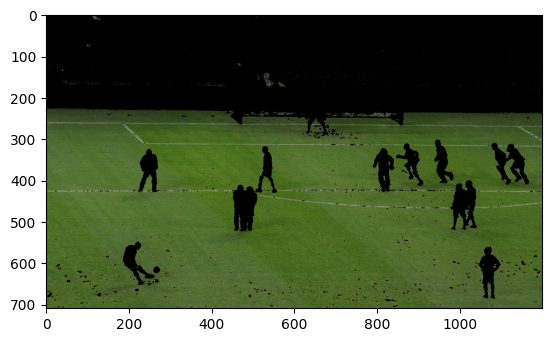

In [6]:
# Try filtering out anything that isn't green

lower_green_hsv = np.array([40,40,40])
upper_green_hsv = np.array([70, 255,255])

hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(hsv_img, lower_green_hsv, upper_green_hsv)

masked_img = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)
masked_img = cv2.cvtColor(masked_img,cv2.COLOR_HSV2RGB)

plt.imshow(masked_img)
plt.show()



### Find some edges

First apply a canny filter to get a binary image for input into hough / houghP

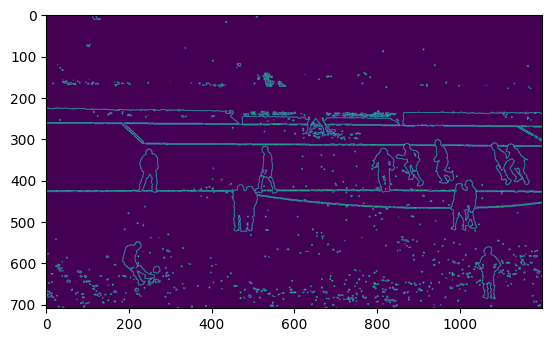

(709, 1200)


In [7]:
canny = cv2.Canny(masked_img, 100, 200, None, 3)

plt.imshow(canny)
plt.show()
print(canny.shape)

### Hough

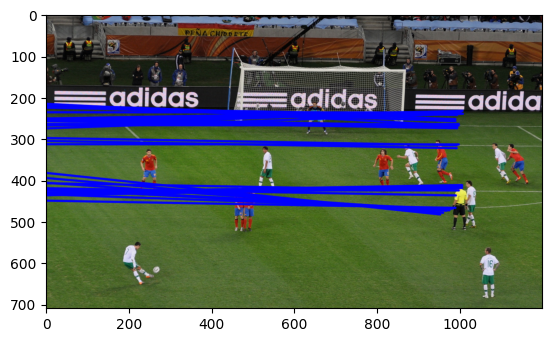

In [8]:
hough_lines = cv2.HoughLines(canny, 1, np.pi / 180, 150, None, 0, 0)

hough_img = np.copy(img)

for i in range(0, len(hough_lines)):
    rho = hough_lines[i][0][0]
    theta = hough_lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(hough_img, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

plt.imshow(hough_img)
plt.show()



Initial attempt at running hough not working great
finding some lines in the horizontal direction, but none in the vertical - likely because the only vertical lines in this image are the six-yard box and this is too short
It also picks up on some lines along the D above the penalty area as this is almost straight. Finding parameters that exclude this but allow for the six yard box will be very tricky

There's also some grain in that direction but that isn't something that can be relied upon for every pitch so best not used.


### Probabilistic hough

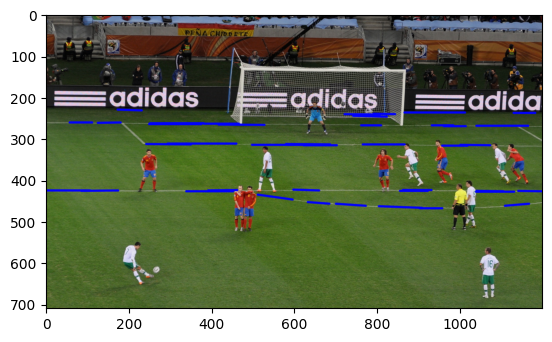

In [9]:
hough_p_img = np.copy(img)

hough_p_lines = cv2.HoughLinesP(canny, 1, np.pi/180, threshold=10, minLineLength=50, maxLineGap=5)
for line in hough_p_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_p_img, (x1, y1), (x2, y2), (0,0,255), 3, cv2.LINE_AA)

plt.imshow(hough_p_img)
plt.show()


This works better; it's able to pick up the six yard box lines, some playing with parameters may be necessary to avoid picking up the D (but we don't want to overfit to this one example image either)

### Line Segment Detector


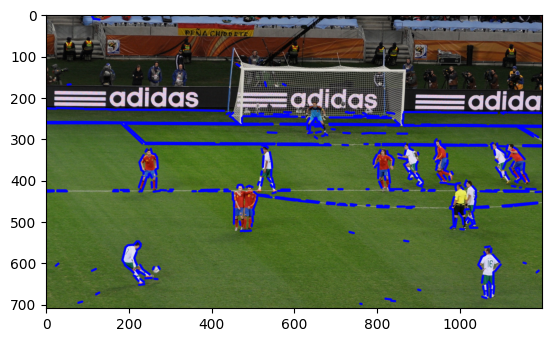

In [10]:
grayscale_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

lsd = cv2.createLineSegmentDetector()
segment_lines = lsd.detect(grayscale_img)[0]

line_segment_detector_img = np.copy(img)

for line in segment_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_segment_detector_img, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 3, cv2.LINE_AA)

plt.imshow(line_segment_detector_img)
plt.show()


This picks up too many lines to be usable, especially around the players

## Form a box

hough_p performed the best of those so we'll use that for now

The next step is to try and form a box from those lines so that the corner points can be provided for a perspective transform

### Idea 1
1. Cluster the lines into two groups (these should turn out to be horizontal and vertical)
2. Take the further lines in each cluster
3. Extend these lines until intersection to produce a rectangle
4. Feed these into perspective transform

Visually looking at the results of the hough_p this might work ok, but it's hard to tell if that will generalise.
In this example we've only picked up two vertical lines so hopefully they will form a cluster on their own
The horizontal lines are trickier because it's also picked up the top of the D. That isn't correct but it will probably be ok because it's a close enough approximation to the other lines for now.

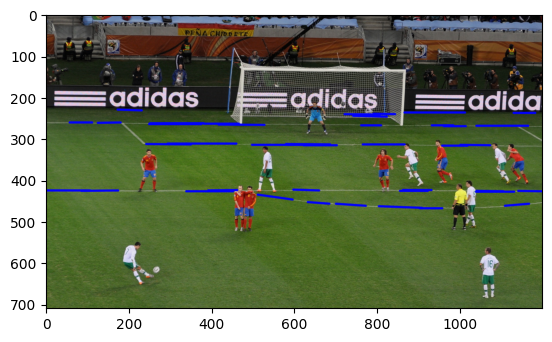

In [11]:
# show hough_p again to go with above commentary
plt.imshow(hough_p_img)
plt.show()

In [12]:
lines_with_angles = []

LineWithAngle = namedtuple('LineWithAngle', ['m', 'p1', 'p2'])

for line in hough_p_lines:
    x1, y1, x2, y2 = line[0]
    m = (y2 - y1) / (x2 - x1)
    lines_with_angles.append(LineWithAngle(m, (x1,y1), (x2,y2)))


# Do a very crude clustering for now based on the largest gap between any two lines once sorted
lines_with_angles.sort(key = lambda line: line.m)


maxdiff = -1
partition_index = 0

for i in range(len(lines_with_angles) - 1):
    diff = lines_with_angles[i + 1].m - lines_with_angles[i].m
    if diff > maxdiff:
        maxdiff = diff
        partition_index = i+1

# 'horizontal' lines will be in the first cluster because they will have a near 0 gradient
horizontal_lines = lines_with_angles[:partition_index]
vertical_lines = lines_with_angles[partition_index:]
